In [243]:
import tensorflow as tf
from Functions import *
import pyautogui 
import matplotlib.pyplot as plt
import itertools
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Loading in Dataset

In [334]:
filename = 'fer2013.csv'
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names)
df = df.iloc[1:]
df.head(10)


,emotion,pixels,usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
10,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [82]:
#Im gonna make the same df but with the actual labels instead of 0-6
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
pixls = df['pixels']
label_series = df['emotion']
#replacing each class with its corresponding label by indexing label_map with the class 
label_series=label_series.apply(lambda emotion_class: label_map[int(emotion_class)])
verbaldf = pd.DataFrame()
verbaldf['pixels']=df['pixels']
verbaldf['emotion'] = label_series
verbaldf.head(10)




,pixels,emotion
1,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Anger
2,151 150 147 155 148 133 111 140 170 174 182 15...,Anger
3,231 212 156 164 174 138 161 173 182 200 106 38...,Fear
4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Sad
5,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Neutral
6,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Fear
7,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Sad
8,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Happy
9,85 84 90 121 101 102 133 153 153 169 177 189 1...,Happy
10,255 254 255 254 254 179 122 107 95 124 149 150...,Fear


### Checking Out Our Class Imbalance

In [ ]:
def picfromdf(df,index):
    ''' takes in the image dataframe and and an boservations index location 
    and parses the pixel string and returns the 48,48 image that that string was meant to convey,
    also displays the image '''
    arr = df['pixels'].iloc[index]
    arr = arr.split(' ')
    ans = []
    for i in arr:
        ans.append(int(i))
    return np.array(ans).reshape(48,48)
def genpicdict(df):
    '''To be able to get examples of each picture I made a function that 
    takes in the dataframe and parses it for a picture in 
    each of the classes then it returns a dictionary of those pictures'''
    picdict = {}
    for i in ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']:
        if i not in picdict:
            picdict[i] = picfromdf(df[df['emotion'] == i],1)
    return picdict


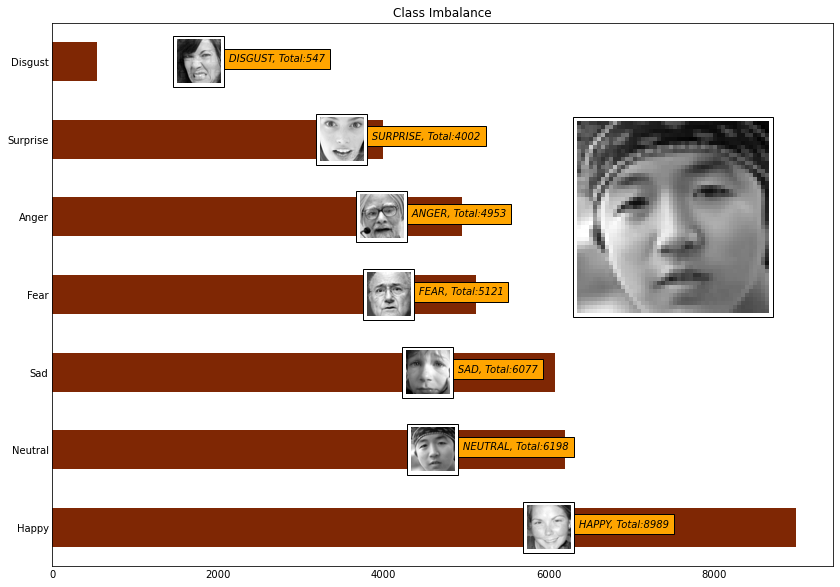

In [328]:
picdict = genpicdict(verbaldf)

ax =  verbaldf['emotion'].value_counts().plot.barh(cmap='Oranges_r',figsize=(14,10))

val_counts = list(verbaldf['emotion'].value_counts().items())

# ax.axis([0, 128, 0, 256])

ax.set_title('Class Imbalance')

ycoord = 0
for tup in val_counts:
    label, count = tup
    spaces = ' '*15
    ax.text(((count/2) -200)+1500, ycoord, f'{spaces}{label.upper()}, Total:{count}', style='italic',
        bbox={'facecolor': 'orange', 'alpha': 1.00, 'pad': 5})
    
    imagebox = OffsetImage(picdict[label], zoom=0.9,cmap='gray')
    ab = AnnotationBbox(imagebox, ((count/2)+1500, ycoord))

    ax.add_artist(ab)

   

    ycoord+=1
ax.tick_params(axis=u'both', which=u'both',length=0)
imagebox = OffsetImage(picdict['Neutral'], zoom=4.0,cmap='gray')
ab = AnnotationBbox(imagebox, (7500, 4))

ax.add_artist(ab)

plt.draw()




The classes are slightly unbalanced and but this didnt seem to hurt anything. Disgust is the one real problem case but from what ive seen the images are very different compared to the other pictures and alot of the models I ran didnt have trouble with it.

## Preparing Data
At this point I dont need to do anything extra to the data besides one hot encoding the labels, turing the dataframe into a tensor, and doing a train test split. 

In [336]:
#split the csv into the x and y so we can do a train test split
X, Y = getData(filename)
num_class = len(set(Y))


In [337]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)
Y = (np.arange(num_class) == Y[:, None]).astype(np.float32)

## Modeling Process
For the sake of this notebooks readability im only going to go over the first, fifth, and final models in this notebook all ten are in my modeling notebook: https://github.com/AmirMEdris/Emotion-classification-from-facial-expression/blob/main/Modeling.ipynb

### Initial model 
#### The first model wasn't made by me, the architecture and weights came from the kaggle user Ashadullah Shawon, his notebook: https://www.kaggle.com/shawon10/facial-expression-detection-cnn

When I first started this project I focused a little too hard on what I would be able to do with a trained model and because of that I used a model that had already done good on the kaggle page for this data. 

In [339]:
Ashadullah_model = Sequential()
input_shape = (48,48,1)
Ashadullah_model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
Ashadullah_model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
Ashadullah_model.add(BatchNormalization())
Ashadullah_model.add(MaxPooling2D(pool_size=(2, 2)))

Ashadullah_model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
Ashadullah_model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
Ashadullah_model.add(BatchNormalization())
Ashadullah_model.add(MaxPooling2D(pool_size=(2, 2)))

Ashadullah_model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
Ashadullah_model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
Ashadullah_model.add(BatchNormalization())
Ashadullah_model.add(MaxPooling2D(pool_size=(2, 2)))

Ashadullah_model.add(Flatten())
Ashadullah_model.add(Dense(128))
Ashadullah_model.add(BatchNormalization())
Ashadullah_model.add(Activation('relu'))
Ashadullah_model.add(Dropout(0.2))
Ashadullah_model.add(Dense(7))
Ashadullah_model.add(Activation('softmax'))

Ashadullah_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
Ashadullah_model.load_weights('firstmodel')



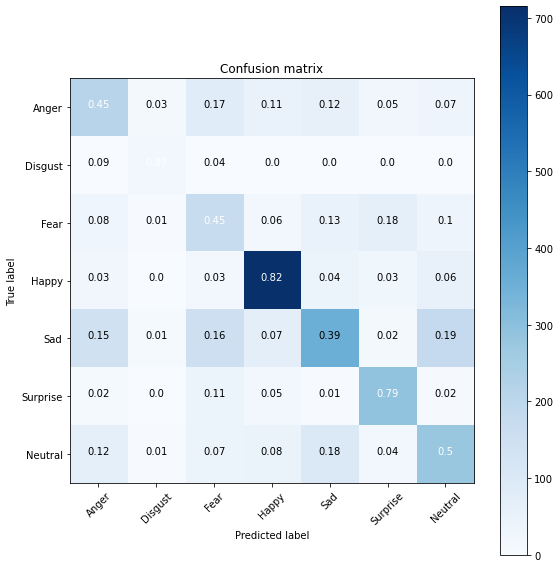

In [340]:
modelaccuracy(Ashadullah_model,X_test,y_test,label_map)

This model had a 57% f1 on the validation set, when I went throug and visualized the differnt activations for this model on some different images and alot of times it would care more about the eye region of a person even if it detected a clear smile which would be fine if the model accuratly extracted eye features but it often didnt and would often get thrown off buy things like bushy eyebrows. This among other things, like moving to google cloud and cutting down my modeling time by a factor of 30, led me to try make the model deeper. At first I was just tweaking the parameters of Ashadullah's model like removing some of the dropout layers to see their overall effect and messing with the distribution of the conv layers. Also I havent taken the time to speak about why I chose f1 and its mostly because I wanted to thing of every class as diferent, there wasnt one specific case that I was targeting.

### Model 5
At this point I had realized a few things, when ever I tried a different loss function, or optimizer the model was eithier untrainable or just alot worse off, also 2 (128,(5,5)) conv layers before a pooling layer did better than one (256,(5,5)) conv layer before pooling, I am not 100% sure but I think the same pattern is happening here with dense neural networks where smaller layers but many of them run faster and will learn bigger features vs one wide layer which will take longer to run and probably not be able to give you a good prediction.

In [343]:
model5 = Sequential()
input_shape = (48,48,1)
model5.add(Conv2D(128, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
model5.add(Conv2D(128, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model5.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())

model5.add(Dense(1200))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.5))

model5.add(Dense(900))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.4))

model5.add(Dense(500))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.2))

model5.add(Dense(125))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Dense(15))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Dense(7))
model5.add(BatchNormalization())
model5.add(Activation('softmax'))

model5.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
model5.load_weights('model5')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for model5

/Users/amirmedris/Desktop/facialexpression/Official/Emoition-classification-from-facial-expression/Functions.py:87: RuntimeWarning: invalid value encountered in true_divide
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


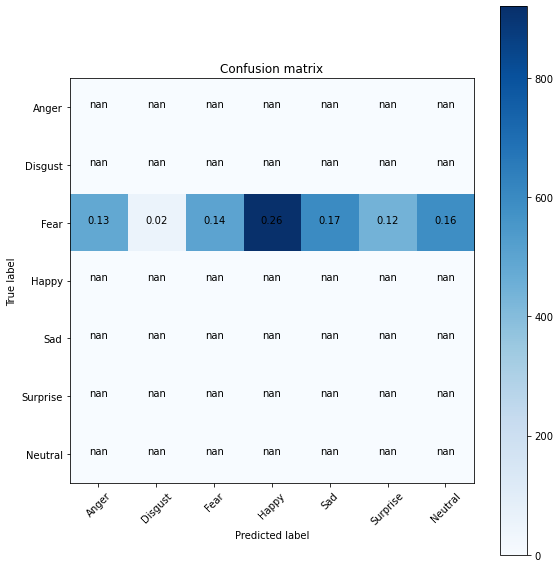

In [342]:
modelaccuracy(model5,X_test,y_test,label_map)


this model was able to do the best in the validation set with 61.2% but it was probably overfit because on the train set it was predicting 85%+ which was weird to me becuase of the 50% dropout rate I put on every dense layer. 

### Final Model
This model had the most consistent accuracy score for both test and train. For me this was big because it got to the same area of 61% f1 that some of my other models did but it was the only one to not be overfit at that accuracy. Between that and my excitement for generating activations for a cnn with 2k+ filters I settled on this model.

In [1]:
# final_model = Sequential()
# input_shape = (48,48,1)
# final_model.add(Conv2D(128, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
# final_model.add(Conv2D(128, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
# final_model.add(Conv2D(128, (5, 5), input_shape=input_shape,activation='relu', padding='same'))

# final_model.add(MaxPooling2D(pool_size=(2, 2)))

# final_model.add(Conv2D(256, (5, 5),activation='relu',padding='same'))
# final_model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))

# final_model.add(MaxPooling2D(pool_size=(2, 2)))

# final_model.add(Conv2D(1024, (3, 3),activation='relu',padding='same'))
# final_model.add(BatchNormalization())
# final_model.add(MaxPooling2D(pool_size=(2, 2)))

# final_model.add(Flatten())
# final_model.add(BatchNormalization())


# final_model.add(Dense(999))
# final_model.add(Activation('relu'))
# final_model.add(Dropout(0.3))
# final_model.add(BatchNormalization())

# final_model.add(Dense(750))
# final_model.add(Activation('relu'))
# final_model.add(Dropout(0.3))

# final_model.add(BatchNormalization())


# final_model.add(Dense(500))
# final_model.add(Activation('relu'))
# final_model.add(Dropout(0.2))

# final_model.add(BatchNormalization())

# final_model.add(Dense(100))
# final_model.add(Activation('relu'))
# final_model.add(Dropout(0.2))

# final_model.add(BatchNormalization())

# final_model.add(Dense(25))
# final_model.add(Activation('relu'))
# final_model.add(Dropout(0.1))

# final_model.add(Dense(7))
# final_model.add(Activation('softmax'))

# final_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
# final_model.load_weights('FinalModel')

In [2]:
# modelaccuracy(final_model,X,Y,label_map)